In [1]:
import requests
import json
import networkx as nx
import matplotlib.pyplot as plt


# Requests
def q(appending):
    url = 'http://api.slowosiec.clarin-pl.eu/plwordnet-api/' + appending
#     print(url)
    r = requests.get(url)
    return json.loads(r.text)

def sense_from_word(w):
    return q('senses/search?lemma=' + str(w))

def synset_from_sense(s_id):
    return q('senses/' + str(s_id) + '/synset')

def sense_from_synset(s_id):
    return q('synsets/' + str(s_id) + '/senses')

def relation_to(s_id):
    return q('synsets/' + str(s_id) + '/relations/to')
    
def relation_from(s_id):
    return q('synsets/' + str(s_id) + '/relations/from')

def realtion_all(s_id):
    return q('synsets/' + str(s_id) + '/relations')

# Processing

def extract_senses(r):
    return [ (i['id'],i['domain']['description']) for i in r['content']]

def extract_synonyms(r):
    ret = []
    for i in range(len(r)):
        ret += [j['lemma'] for j in r[i]]
    ret = [ ret[n] for n in range(len(ret)) if ret[n] not in ret[n+1:]]
    return ret
    
def find_synonyms(w):
    return extract_synonyms([sense_from_synset(i) for i in [synset_from_sense(i)['id'] for i in [i[0] for i in extract_senses(sense_from_word(w))]]])


def remove_duplicates(l):
    return [ l[n] for n in range(len(l)) if l[n] not in l[n+1:]]

In [2]:
word = "szkoda"
res = sense_from_word(word)
res

{'content': [{'id': 8769,
   'domain': {'id': 12,
    'name': 'plWN_msc',
    'description': 'plWN miejsca i umiejscowienie',
    'lexicon': {'id': 1,
     'name': 'Słowosieć 2.2',
     'lexiconIdentifier': 'P 2.2',
     'language': 'pl'}},
   'lemma': {'id': 249489, 'word': 'szkoda'},
   'partOfSpeech': {'id': 2,
    'name': 'plWN rzeczownik',
    'lexicon': {'id': 1,
     'name': 'Słowosieć 2.2',
     'lexiconIdentifier': 'P 2.2',
     'language': 'pl'},
    'lmfType': 'noun'},
   'senseNumber': 1,
   'lexicon': {'id': 1,
    'name': 'Słowosieć 2.2',
    'lexiconIdentifier': 'P 2.2',
    'language': 'pl'}},
  {'id': 8770,
   'domain': {'id': 35,
    'name': 'plWN_cczuj',
    'description': 'plWN czasowniki wyrażające uczucia',
    'lexicon': {'id': 1,
     'name': 'Słowosieć 2.2',
     'lexiconIdentifier': 'P 2.2',
     'language': 'pl'}},
   'lemma': {'id': 249489, 'word': 'szkoda'},
   'partOfSpeech': {'id': 1,
    'name': 'plWN czasownik',
    'lexicon': {'id': 1,
     'name': 'Sł

In [3]:
e = extract_senses(res)
e

[(8769, 'plWN miejsca i umiejscowienie'),
 (8770, 'plWN czasowniki wyrażające uczucia'),
 (8771, 'plWN posiadanie i jego zmiana')]

In [4]:
ids = [i[0] for i in e]
ids

[8769, 8770, 8771]

In [5]:
r = [synset_from_sense(i)['id'] for i in ids]
r2 = [sense_from_synset(i) for i in r]
r2 = extract_synonyms(r2)
r2

[{'id': 300109, 'word': 'żałować'},
 {'id': 300080, 'word': 'żal'},
 {'id': 243080, 'word': 'strata'},
 {'id': 270916, 'word': 'utrata'},
 {'id': 249489, 'word': 'szkoda'},
 {'id': 270658, 'word': 'uszczerbek'}]

In [6]:
r = find_synonyms('szkoda')
r

[{'id': 300109, 'word': 'żałować'},
 {'id': 300080, 'word': 'żal'},
 {'id': 243080, 'word': 'strata'},
 {'id': 270916, 'word': 'utrata'},
 {'id': 249489, 'word': 'szkoda'},
 {'id': 270658, 'word': 'uszczerbek'}]

In [7]:
word = "wypadek drogowy"

res = extract_senses(sense_from_word(word))
ids = [i[0] for i in res]
r = [synset_from_sense(i)['id'] for i in ids]
for i in r:
    candidates = relation_from(i)
    tmp = [c['synsetTo']['id'] for c in candidates if c['relation']['name'] == 'hiponimia' and c['synsetTo']['id'] not in r]
    r += tmp

senses = []
for i in r:
    tmp = []
    s = sense_from_synset(i)
    for j in range(len(s)):
        tmp += [s[j]['lemma']]
    senses += [tmp]

senses

[[{'id': 286392, 'word': 'wypadek drogowy'}],
 [{'id': 286393, 'word': 'wypadek komunikacyjny'}],
 [{'id': 286391, 'word': 'wypadek'}],
 [{'id': 294893, 'word': 'zdarzenie oceniane negatywnie'}],
 [{'id': 284803, 'word': 'wydarzenie'},
  {'id': 101333, 'word': 'historia'},
  {'id': 286391, 'word': 'wypadek'},
  {'id': 294891, 'word': 'zdarzenie'}]]

{('wypadek drogowy | ',
  'wypadek komunikacyjny | '): Text(0.5408241255722683, 0.7470928345580601, 'hiper'),
 ('wypadek komunikacyjny | ',
  'wypadek | '): Text(0.1858665260528608, 0.24499922228401252, 'hiper'),
 ('wypadek | ',
  'zdarzenie oceniane negatywnie | '): Text(-0.17607617366196732, -0.25210324546737073, 'hiper'),
 ('zdarzenie oceniane negatywnie | ',
  'wydarzenie | historia | wypadek | zdarzenie | '): Text(-0.5437049823085958, -0.7449992222840125, 'hiper')}

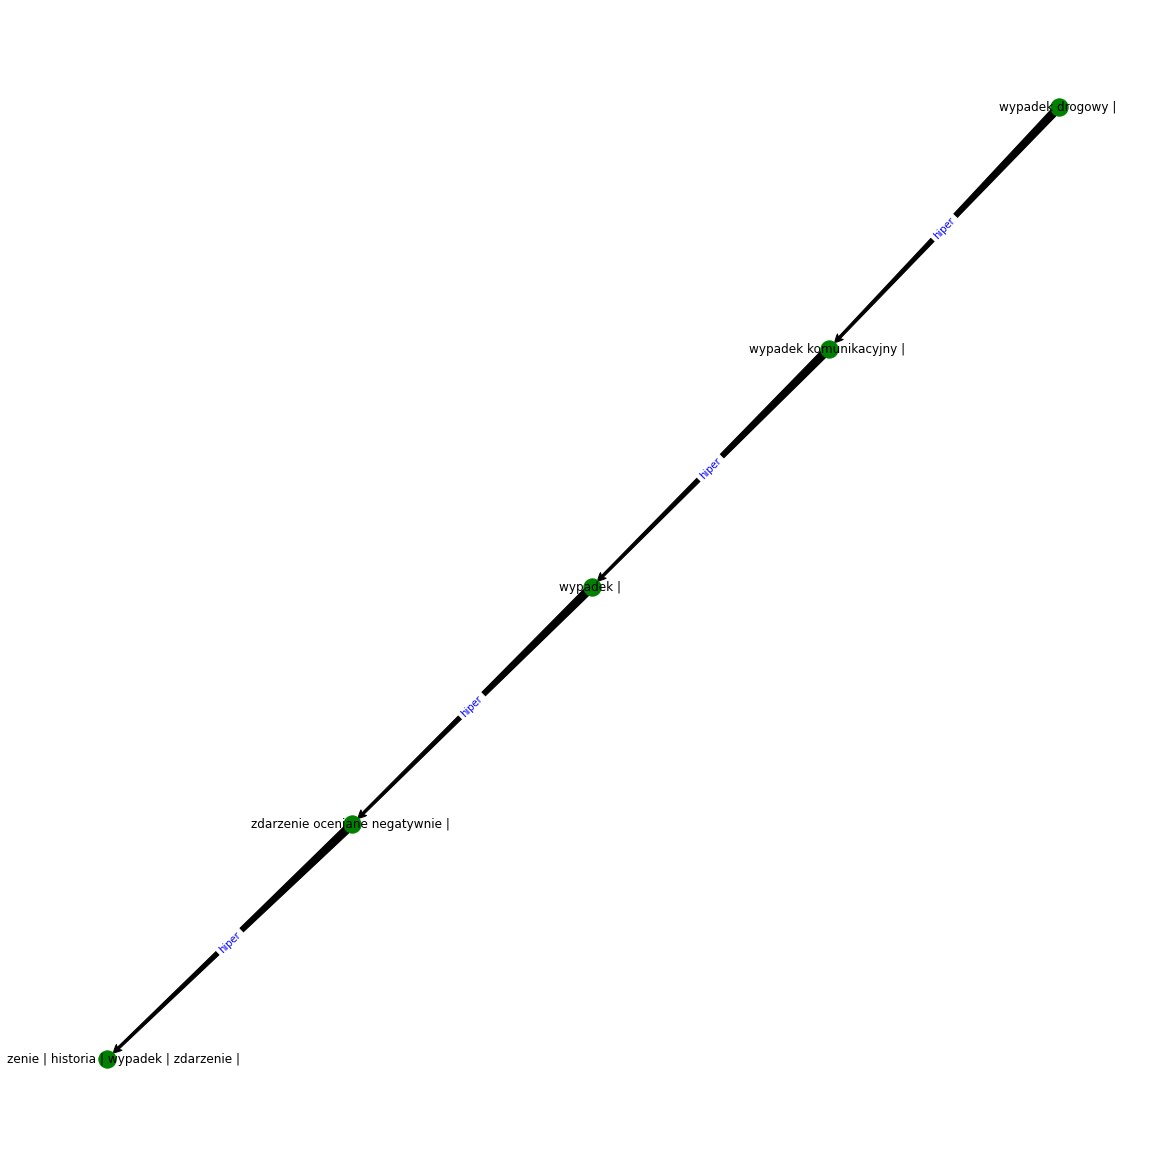

In [8]:
# TODO: zrobić graf
edges = []
edges_labels = {}
for i in range(len(senses)-1):
    n1 = ''
    n2 = ''
    for j in range(len(senses[i])):
        n1 += senses[i][j]['word'] + ' | '
    for j in range(len(senses[i+1])):
        n2 += senses[i+1][j]['word'] + ' | '
        
    edges += [[n1,n2]]
    edges_labels[(n1,n2)] = 'hiper'

G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(16, 16))
pos = nx.kamada_kawai_layout(G)
nx.draw(G,pos, edge_color='black', node_color='green', labels={node:node for node in G.nodes()}, arrowsize=20, arrowstyle='fancy')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edges_labels, font_color='blue', arrowstyle='->')


In [9]:
word = "wypadek"

res = extract_senses(sense_from_word(word))
ids = [i[0] for i in res]
ids = [ids[0]]
r = [synset_from_sense(i)['id'] for i in ids]

res = []
for i in r:
    candidates = relation_from(i)
    tmp = [c['synsetTo']['id'] for c in candidates if c['relation']['name'] == 'hiperonimia' and c['synsetTo']['id'] not in res]
    res += tmp
    
# senses = [(sense_from_synset(i)[0]['lemma'],sense_from_synset(i)[0]['id']) for i in res]
# senses = [ senses[n] for n in range(len(senses)) if senses[n] not in senses[n+1:]]
# senses


senses = []
for i in res:
    tmp = []
    s = sense_from_synset(i)
    for j in range(len(s)):
        tmp += [(s[j]['lemma'],s[j]['id'])]
    senses += [tmp]
senses = [ senses[n] for n in range(len(senses)) if senses[n] not in senses[n+1:]]
senses

[[({'id': 294092, 'word': 'zawał'}, 52898)],
 [({'id': 253959, 'word': 'tąpnięcie'}, 52894)],
 [({'id': 117781, 'word': 'katastrofa'}, 19923)],
 [({'id': 285527, 'word': 'wykolejenie'}, 393642)],
 [({'id': 291365, 'word': 'zakrztuszenie'}, 618773),
  ({'id': 289786, 'word': 'zachłyśnięcie'}, 618779)],
 [({'id': 286393, 'word': 'wypadek komunikacyjny'}, 644778)],
 [({'id': 117782, 'word': 'katastrofa budowlana'}, 645560)]]

{('wypadek', 'zawał | '): Text(0.4821616443586727, 0.4326666627761673, 'hipo'),
 ('wypadek',
  'tąpnięcie | '): Text(0.14928593535130702, 0.49999997046037487, 'hipo'),
 ('wypadek',
  'katastrofa | '): Text(-0.1574969249362403, 0.33419679152315934, 'hipo'),
 ('wypadek',
  'wykolejenie | '): Text(-0.2838575706986419, -5.955697363320369e-08, 'hipo'),
 ('wypadek',
  'zakrztuszenie | zachłyśnięcie | '): Text(-0.15749695122074714, -0.3341968019999002, 'hipo'),
 ('wypadek',
  'wypadek komunikacyjny | '): Text(0.14928596148296627, -0.5000000143764163, 'hipo'),
 ('wypadek',
  'katastrofa budowlana | '): Text(0.4821616057697835, -0.43266672606416223, 'hipo')}

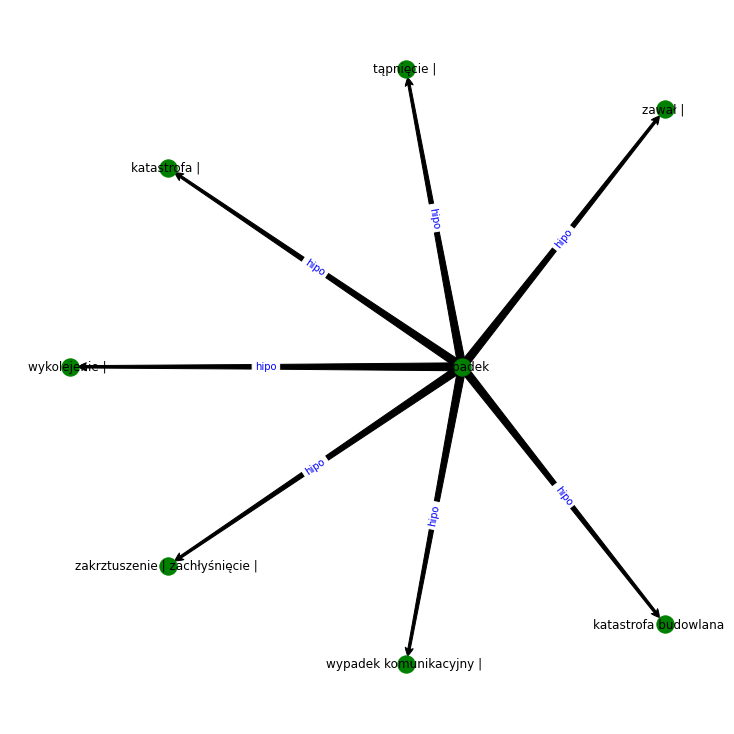

In [10]:
# TODO: zrobić graf
edges = []
edges_labels = {}
for i in range(len(senses)):
    n1 = 'wypadek'
    n2 = ''
    for j in range(len(senses[i])):
        n2 += senses[i][j][0]['word'] + ' | '
        
    edges += [[n1,n2]]
    edges_labels[(n1,n2)] = 'hipo'

G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G,pos, edge_color='black', node_color='green', labels={node:node for node in G.nodes()}, arrowsize=20, arrowstyle='fancy')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edges_labels, font_color='blue', arrowstyle='->')


In [11]:
def direct_hyponyms(ids):
    r = [synset_from_sense(i)['id'] for i in ids]

    res = []
    for i in r:
        candidates = relation_from(i)
        tmp = [c['synsetTo']['id'] for c in candidates if c['relation']['name'] == 'hiperonimia' and c['synsetTo']['id'] not in res]
        res += tmp

#     senses = [sense_from_synset(i)[0]['lemma'] for i in res]
    senses = []
    for i in res:
        tmp = []
        s = sense_from_synset(i)
        for j in range(len(s)):
            tmp += [(s[j]['lemma'],s[j]['id'])]
        senses += [tmp]

    return remove_duplicates(senses)

In [12]:
senses

[[({'id': 294092, 'word': 'zawał'}, 52898)],
 [({'id': 253959, 'word': 'tąpnięcie'}, 52894)],
 [({'id': 117781, 'word': 'katastrofa'}, 19923)],
 [({'id': 285527, 'word': 'wykolejenie'}, 393642)],
 [({'id': 291365, 'word': 'zakrztuszenie'}, 618773),
  ({'id': 289786, 'word': 'zachłyśnięcie'}, 618779)],
 [({'id': 286393, 'word': 'wypadek komunikacyjny'}, 644778)],
 [({'id': 117782, 'word': 'katastrofa budowlana'}, 645560)]]

In [13]:
first_order_hyponyms = senses

second_order_hyponyms = []

for j in senses:
    i = j[0]
    candidates = direct_hyponyms([i[1]])
    second_order_hyponyms += [(j,c) for c in candidates if c not in first_order_hyponyms]

second_order_hyponyms = remove_duplicates(second_order_hyponyms)
second_order_hyponyms

[([({'id': 294092, 'word': 'zawał'}, 52898)],
  [({'id': 165422, 'word': 'obwał'}, 56050)]),
 ([({'id': 286393, 'word': 'wypadek komunikacyjny'}, 644778)],
  [({'id': 286392, 'word': 'wypadek drogowy'}, 644786)])]

In [14]:
first_order_hyponyms

[[({'id': 294092, 'word': 'zawał'}, 52898)],
 [({'id': 253959, 'word': 'tąpnięcie'}, 52894)],
 [({'id': 117781, 'word': 'katastrofa'}, 19923)],
 [({'id': 285527, 'word': 'wykolejenie'}, 393642)],
 [({'id': 291365, 'word': 'zakrztuszenie'}, 618773),
  ({'id': 289786, 'word': 'zachłyśnięcie'}, 618779)],
 [({'id': 286393, 'word': 'wypadek komunikacyjny'}, 644778)],
 [({'id': 117782, 'word': 'katastrofa budowlana'}, 645560)]]

{('wypadek',
  'zawał | '): Text(0.12260519143955294, 0.055533142798794635, 'hipo'),
 ('wypadek',
  'tąpnięcie | '): Text(0.06333942485516632, 0.5533763440209444, 'hipo'),
 ('wypadek',
  'katastrofa | '): Text(-0.18108028559116213, 0.6133937791275237, 'hipo'),
 ('wypadek',
  'wykolejenie | '): Text(-0.4417936697278367, 0.4200388489881829, 'hipo'),
 ('wypadek',
  'zakrztuszenie | zachłyśnięcie | '): Text(-0.4298782151106217, 0.11155864806559485, 'hipo'),
 ('wypadek',
  'wypadek komunikacyjny | '): Text(-0.025198709628107246, -0.04383293870587651, 'hipo'),
 ('wypadek',
  'katastrofa budowlana | '): Text(-0.10710679087044747, -0.060693948703985645, 'hipo'),
 ('zawał | ',
  'obwał | '): Text(0.6251121299897356, -0.4001584773694666, 'hipo'),
 ('wypadek komunikacyjny | ',
  'wypadek drogowy | '): Text(0.20337595752890064, -0.6825693897904599, 'hipo')}

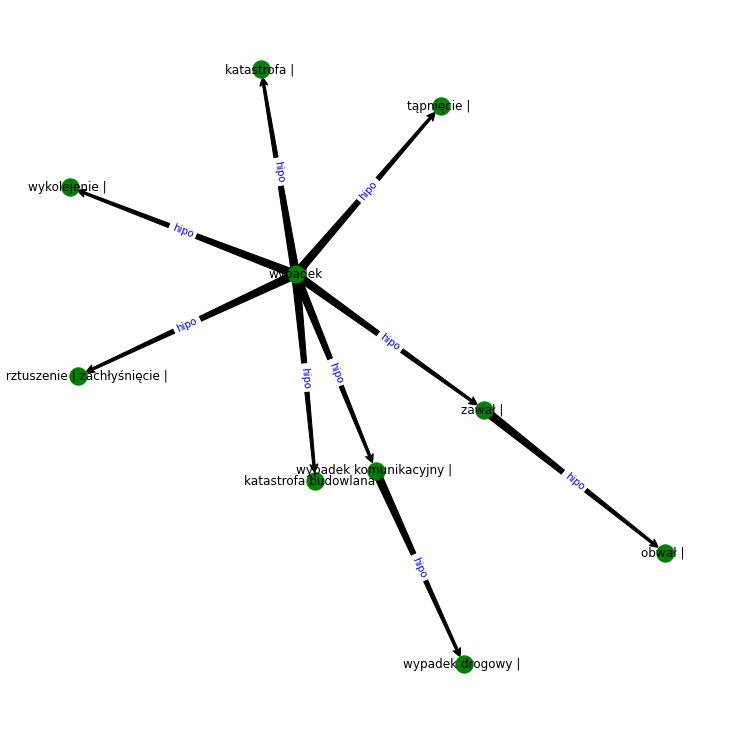

In [15]:
# TODO: zrobić graf
edges = []
edges_labels = {}
for i in range(len(first_order_hyponyms)):
    n1 = 'wypadek'
    n2 = ''
    for j in range(len(senses[i])):
        n2 += senses[i][j][0]['word'] + ' | '
        
    edges += [[n1,n2]]
    edges_labels[(n1,n2)] = 'hipo'

for i in second_order_hyponyms:
    s,d = i
    n1 = ''
    for j in range(len(s)):
        n1 += s[j][0]['word'] + ' | '
    
    n2 = ''
    for j in range(len(d)):
        n2 += d[j][0]['word'] + ' | '
        
        
    edges += [[n1,n2]]
    edges_labels[(n1,n2)] = 'hipo'
    
G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G,pos, edge_color='black', node_color='green', labels={node:node for node in G.nodes()}, arrowsize=20, arrowstyle='fancy')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edges_labels, font_color='blue', arrowstyle='->')


In [16]:
# Display as a directed graph (with labels for the edges) semantic relations between the following groups of lexemes:
# szkoda2, strata1, uszczerbek1, szkoda majątkowa1, uszczerbek na zdrowiu1, krzywda1, niesprawiedliwość1, nieszczęście2.
words1 = [('szkoda',2),('strata',1),('uszczerbek',1),('szkoda majątkowa',1),('uszczerbek na zdrowiu',1),('krzywda',1),('niesprawiedliwość',1),('nieszczęście',2)]
words2 = [('wypadek',1), ('wypadek komunikacyjny',1), ('kolizja',2), ('zderzenie',2), ('kolizja drogowa',1), ('bezkolizyjny',2), ('katastrofa budowlana',1), ('wypadek drogowy',1)]


def create_graph(words1):
    senses1 = [ (word,extract_senses(sense_from_word(word)),i) for word,i in words1]
    senses1_filtered = [ i for i in senses1 if len(i[1]) != 0]
    senses1_proper = [ (w,s[c-1]) for w,s,c in senses1_filtered]
    synsets1 = [ (w,synset_from_sense(s[0])['id']) for w,s in senses1_proper]
    synsets1_merged = {}
    print(synsets1)
    for s in synsets1:
        x = synsets1_merged.get(s[1],[])
        x.append(s[0])
        synsets1_merged[s[1]] = x
    print(synsets1_merged)
    for s in synsets1_merged:
        x = synsets1_merged[s]
        relations = relation_to(s)
        relations_to_dict = []
        for r in relations:
            f = r['synsetFrom']["id"]
            t = r['synsetTo']["id"]
            typ = r['relation']['name']
            relations_to_dict += [(f,t,typ)]
        synsets1_merged[s] = (x,relations_to_dict)
    
    nodes = synsets1_merged.keys()
    
    for n in nodes:
        words,relations = synsets1_merged[n]
        relations = [ r for r in relations if r[0] in nodes and r[2] == 'hiponimia']
        synsets1_merged[n] = (words,relations)
    
    edges = []
    edges_labels = {}
    for i in synsets1_merged:
        wordsn1,relations = synsets1_merged[i]
        if len(relations) == 0:
            continue
        n1 = ''
        for w in wordsn1:
            n1 += w + ' |'
        
        for s,d,t in relations:
            wordsn2,_ = synsets1_merged[s]
            n2 = ''
            for w in wordsn2:
                n2 += w + ' |'
            edges += [[n1,n2]]
            edges_labels[(n1,n2)] = 'hipo'

    G = nx.DiGraph()
    G.add_edges_from(edges)

    plt.figure(figsize=(10, 10))
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G,pos, edge_color='black', node_color='green', labels={node:node for node in G.nodes()}, arrowsize=20, arrowstyle='fancy')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edges_labels, font_color='blue', arrowstyle='->')
    

# senses2 = [ (word,extract_senses(s))[] for w,s in senses1]



# wypadek1, wypadek komunikacyjny1, kolizja2, zderzenie2, kolizja drogowa1, bezkolizyjny2, katastrofa budowlana1, wypadek drogowy1.

[('szkoda', 3411), ('strata', 3675), ('uszczerbek', 3675), ('uszczerbek na zdrowiu', 46769), ('krzywda', 1439), ('niesprawiedliwość', 1439), ('nieszczęście', 5640)]
{3411: ['szkoda'], 3675: ['strata', 'uszczerbek'], 46769: ['uszczerbek na zdrowiu'], 1439: ['krzywda', 'niesprawiedliwość'], 5640: ['nieszczęście']}


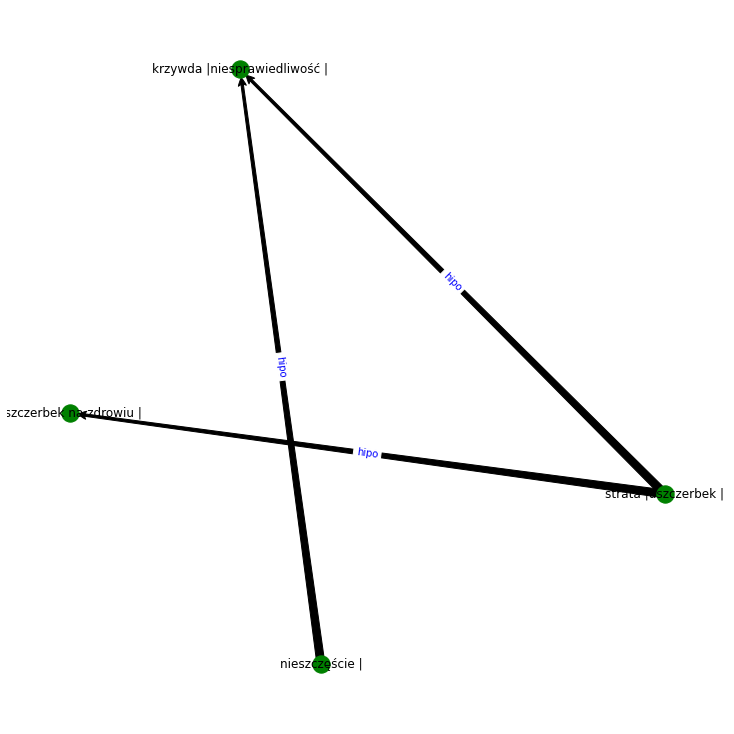

In [17]:
create_graph(words1)

[('wypadek', 3982), ('wypadek komunikacyjny', 410901), ('kolizja', 6486), ('zderzenie', 1284), ('kolizja drogowa', 6486), ('bezkolizyjny', 228740), ('katastrofa budowlana', 411618), ('wypadek drogowy', 410902)]
{3982: ['wypadek'], 410901: ['wypadek komunikacyjny'], 6486: ['kolizja', 'kolizja drogowa'], 1284: ['zderzenie'], 228740: ['bezkolizyjny'], 411618: ['katastrofa budowlana'], 410902: ['wypadek drogowy']}


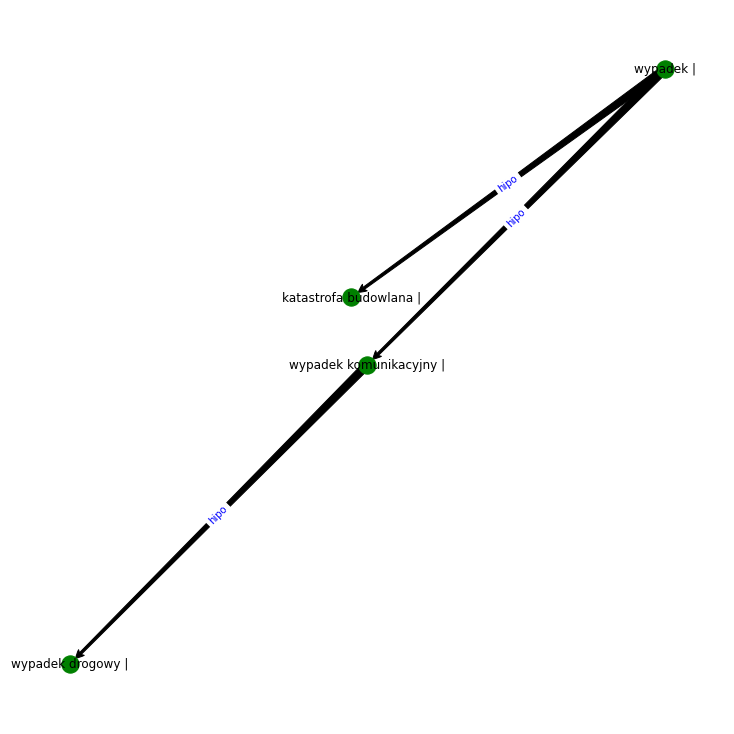

In [18]:
create_graph(words2)

In [20]:
from nltk.corpus import wordnet as wn
import queue
from math import log

def lc_similarity(distance,max_distance):
    return -log((distance + 1) / (2.0 * max_distance))

def find_sp(s1,s2,max_distance = 40):
    pq = queue.PriorityQueue()
    pq.put((0,s1))
    visited = set()
    while pq.empty() == False:
        distance, cs_id = pq.get()
        if cs_id not in visited:
            visited.add(cs_id)
            relations = realtion_all(cs_id)
            
            for r in relations:
                s,d = r['synsetFrom'],r['synsetTo']
                if s['id'] == s2 or d['id'] == s2:
                    return distance + 1
                if s['id'] and distance < max_distance:
                    pq.put((distance+1,s['id']))
                if d['id'] and distance < max_distance:
                    pq.put((distance+1,d['id']))
    return -1



pairs = [ 
    [('szkoda',2), ('wypadek',1)] , 
    [('kolizja',2), ('szkoda majątkowa',1)] , 
    [('nieszczęście',2), ('katastrofa budowlana',1)]
]

pairs_with_senses = []
for p1,p2 in pairs:
    w1,n1 = p1
    w2,n2 = p2
    s1,s2 = extract_senses(sense_from_word(w1)),extract_senses(sense_from_word(w2))
    
    if len(s1) < n1 or len(s2) < n2:
        print("Could find propper sens for pair {} {}".format(w1,w2))
        continue
    ps1, ps2 = s1[n1-1],s2[n2-1]
    syn1, syn2 = synset_from_sense(ps1[0]),synset_from_sense(ps2[0])
    sp = find_sp(syn1['id'],syn2['id'],40)
    if sp < 0:
        print("Couldnt find SP for pair {} {}".format(w1,w2))
    else:
        v = lc_similarity(sp,40)
        print("LC similarity for {} {} is {} and shortest path is: {}".format(w1,w2,v,sp))





LC similarity for szkoda wypadek is 2.5902671654458267 and shortest path is: 5
Could find propper sens for pair kolizja szkoda majątkowa
LC similarity for nieszczęście katastrofa budowlana is 2.5902671654458267 and shortest path is: 5


# Questions/problems:

#### What is the necessary step to use the knowlege from dictionaries such as WordNet?

To make basic steps not so much only browsers will do.
But to understand it and use it properly you need to know about the dictionary construction, knowledge about relations between words. Getting to know API. Preparation of such dict takes massive time, considering the time invested to create a dictionary the documentation could be better.

#### Assess the value of WordNet as a resource for representing the sense of sentences (not words in isolation).

It can be very useful for automatic analysis using AI. For example it gives the possibility to match words with their senses by minimizing the distance between all of them. It could be useful for analysing semantic value between sentences.


#### Discuss the problmes comming from using structured knowledge resources such as WordNet.
Using it requires more than just searching like in a basic dictionary.
First steps are harder because you need to get to know the architecture of the data. You need to know how to use it effectively. 
Like most things. If it is more sophisticated you can probably use it more efficiently than the basic type but if you will use it better that depends on your knowledge and experience.

